# New York Housing Predicative Model

## Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split


## Load Data and Clean

In [29]:
df = pd.read_csv("NY-House-Dataset.csv")
df

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.000000,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.000000,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.000000,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.000000,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.000000,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,Brokered by COMPASS,Co-op for sale,599000,1,1.000000,2184.207862,222 E 80th St Apt 3A,"Manhattan, NY 10075","222 E 80th St Apt 3AManhattan, NY 10075",New York,New York County,New York,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879
4797,Brokered by Mjr Real Estate Llc,Co-op for sale,245000,1,1.000000,2184.207862,97-40 62 Dr Unit Lg,"Rego Park, NY 11374","97-40 62 Dr Unit LgRego Park, NY 11374",United States,New York,Queens County,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152
4798,Brokered by Douglas Elliman - 575 Madison Ave,Co-op for sale,1275000,1,1.000000,2184.207862,427 W 21st St Unit Garden,"New York, NY 10011","427 W 21st St Unit GardenNew York, NY 10011",United States,New York,New York County,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398
4799,Brokered by E Realty International Corp,Condo for sale,598125,2,1.000000,655.000000,91-23 Corona Ave Unit 4G,"Elmhurst, NY 11373","91-23 Corona Ave Unit 4GElmhurst, NY 11373",New York,Queens County,Queens,Flushing,91-23,"91-23 Corona Ave. #4b, Flushing, NY 11373, USA",40.742770,-73.872752


In [30]:
df['ZIPCODE'] = df['STATE'].str.extract(r'([0-9]{5})', expand=True)
df['TYPE'] = df['TYPE'].str.replace(" for sale", "")
df['ADDRESS'] = df['ADDRESS'].str.replace(r"", "")
df['BROKERTITLE'] = df['BROKERTITLE'].str.replace("Brokered by ", "")
#df['SUBLOCALITY'] = np.where(df['SUBLOCALITY'] == "New York County", "Manhattan", df['SUBLOCALITY'])
#df['SUBLOCALITY'] = np.where(df['SUBLOCALITY'] == "Kings County", "Brooklyn", df['SUBLOCALITY'])

#### Drop features that won't be used for the model

In [31]:
df = df.drop(columns=['ADDRESS', 'STATE', 'LONG_NAME', 'BROKERTITLE', 'ADMINISTRATIVE_AREA_LEVEL_2', 'FORMATTED_ADDRESS', 'MAIN_ADDRESS'], axis=1)
df = df.loc[df.PRICE < 1e8]
price_col = df.pop('PRICE')
df.insert(column='PRICE', loc=len(df.columns), value=price_col)
df = df.reset_index().drop('index', axis=1)
df

,TYPE,BEDS,BATH,PROPERTYSQFT,LOCALITY,SUBLOCALITY,STREET_NAME,LATITUDE,LONGITUDE,ZIPCODE,PRICE
0,Condo,2,2.000000,1400.000000,New York,Manhattan,East 55th Street,40.761255,-73.974483,10022,315000
1,House,4,2.000000,2015.000000,New York,Richmond County,Staten Island,40.541805,-74.196109,10312,260000
2,Condo,3,1.000000,445.000000,New York,New York County,New York,40.761398,-73.974613,10022,69000
3,Townhouse,7,2.373861,14175.000000,New York,New York County,New York,40.767224,-73.969856,10065,55000000
4,House,5,2.000000,4004.000000,New York,Kings County,Brooklyn,40.674363,-73.958725,11238,690000
...,...,...,...,...,...,...,...,...,...,...,...
4794,Co-op,1,1.000000,2184.207862,New York County,New York,Manhattan,40.774350,-73.955879,10075,599000
4795,Co-op,1,1.000000,2184.207862,New York,Queens County,Queens,40.732538,-73.860152,11374,245000
4796,Co-op,1,1.000000,2184.207862,New York,New York County,New York,40.745882,-74.003398,10011,1275000
4797,Condo,2,1.000000,655.000000,Queens County,Queens,Flushing,40.742770,-73.872752,11373,598125


## Data Visualization
Plot Feature relationships to price

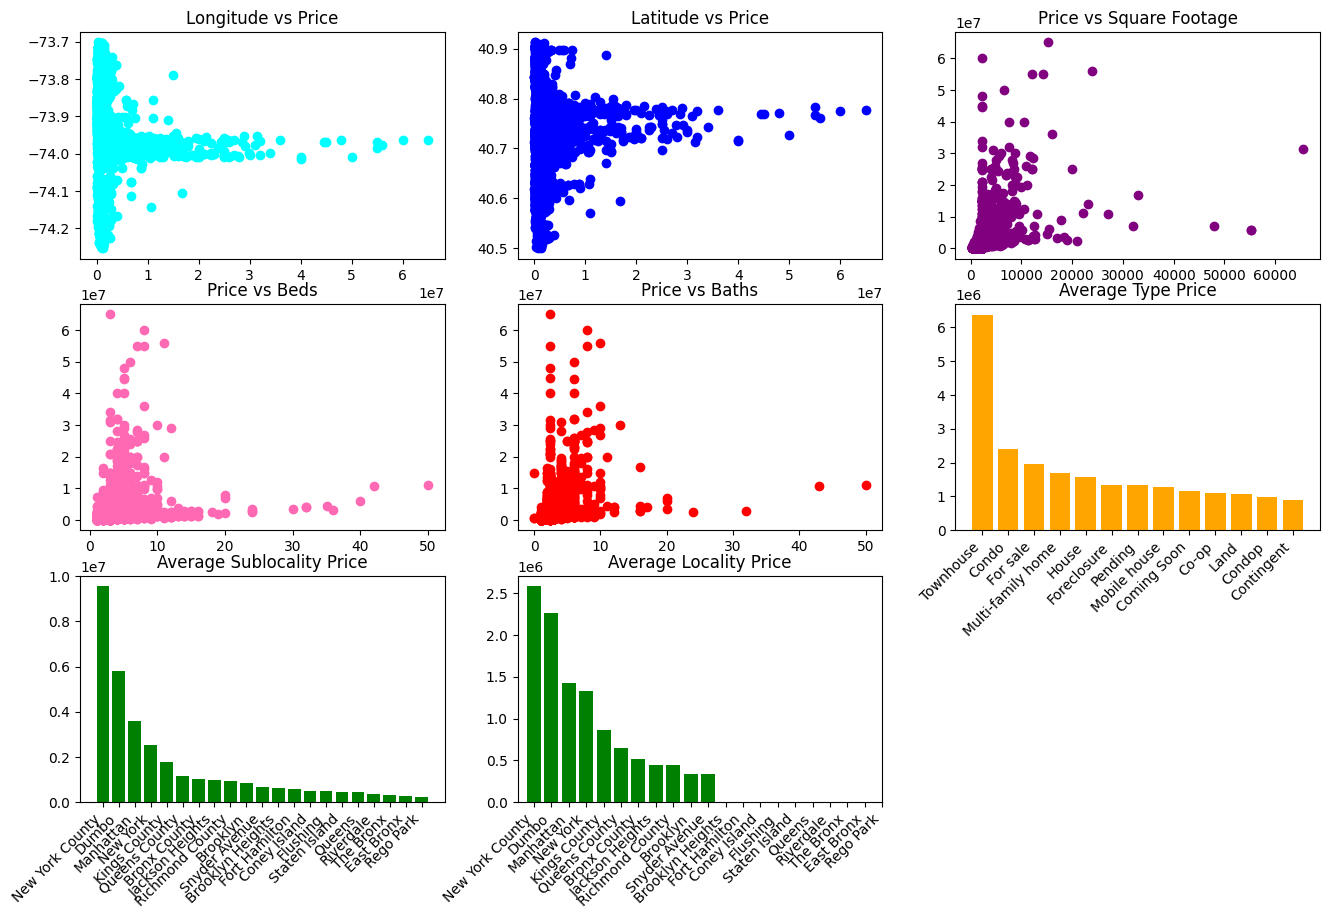

In [32]:
# Data
price = df.PRICE
lon = df.LONGITUDE
lat = df.LATITUDE
sqr_feet = df.PROPERTYSQFT
bed = df.BEDS
bath = df.BATH

# Create a grid a subplots
fig, axs = plt.subplots(3, 3, figsize=(16,10))

# Plot the data
axs[0, 0].scatter(price, lon, label='longitude', color='cyan')
axs[0, 0].set_title("Longitude vs Price")

axs[0, 1].scatter(price, lat, label='latitude', color='blue')
axs[0, 1].set_title("Latitude vs Price")

axs[0, 2].scatter(sqr_feet, price, label='square feet', color='purple')
axs[0, 2].set_title("Price vs Square Footage")

axs[1, 0].scatter(bed, price, label='beds', color='hotpink')
axs[1, 0].set_title("Price vs Beds")

axs[1, 1].scatter(bath, price, label='baths', color='red')
axs[1, 1].set_title("Price vs Baths")

type_gb = df.groupby('TYPE')['PRICE'].mean().sort_values(ascending=False)
axs[1, 2].bar(type_gb.index, type_gb.values, label='type', color='orange')
axs[1, 2].set_title("Average Type Price")
axs[1, 2].set_xticks(axs[1, 2].get_xticks())
axs[1, 2].set_xticklabels(axs[1, 2].get_xticklabels(), rotation=45, ha='right')

sublocality_gb = df.groupby('SUBLOCALITY')['PRICE'].mean().sort_values(ascending=False)
axs[2, 0].bar(sublocality_gb.index, sublocality_gb.values, label='sublocality', color='green')
axs[2, 0].set_title("Average Sublocality Price")
axs[2, 0].set_xticks(axs[2, 0].get_xticks())
axs[2, 0].set_xticklabels(axs[2, 0].get_xticklabels(), rotation=45, ha='right')

locality_gb = df.groupby('LOCALITY')['PRICE'].mean().sort_values(ascending=False)
axs[2, 1].bar(locality_gb.index, locality_gb.values, label='locality', color='green')
axs[2, 1].set_title("Average Locality Price")
axs[2, 1].set_xticks(axs[2, 0].get_xticks())
axs[2, 1].set_xticklabels(axs[2, 0].get_xticklabels(), rotation=45, ha='right')

# Leave the last row empty
axs[2, 2].axis('off')

plt.show()

## K-Means Clustering
Is this portion I use K-Means Clustering to group cluster each sale by the longitude, latitude, and price. Clusering the data by these features helps when modeling in the future because the price can't be scaled with longitude and latitude.

#### K-Means algorithm

In [33]:
import numpy as np

def kmeans_alt(X, k, max_iter=100):
    
    # randomly initialize k centroids
    Mu = X[np.random.choice(X.shape[0], size=k, replace=False)]
    # choose initial means using kmeans++
    #Mu = kmeans_pp(flatten_images, k)
    prev_loss = np.inf
    for i in range(max_iter):
        # assign each data point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis, :] - Mu, axis=2)
        cluster_assignment = np.argmin(distances, axis=1)

        # compute loss function
        loss = np.sum(np.square(np.min(distances, axis=1)))
        
        # recompute centroids as the mean of the assigned data points
        for j in range(k):
            Mu[j] = np.mean(X[cluster_assignment == j], axis=0)

        # check for convergence
        if np.abs(prev_loss - loss) < 1e-5:
            break
        prev_loss = loss
    return cluster_assignment, Mu, loss

<AxesSubplot: xlabel='LOCALITY'>

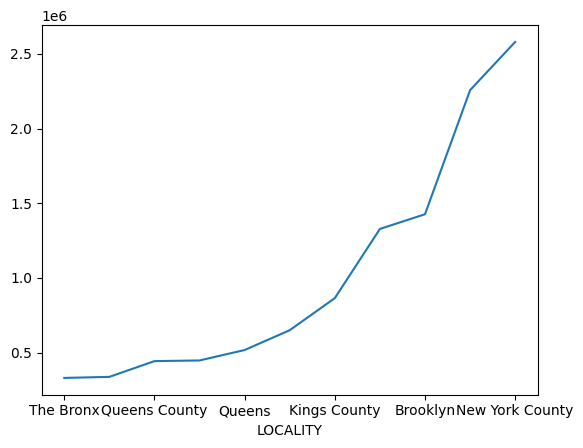

In [34]:
#df.plot.scatter(x='LOCALITY', y='PRICE')
df.groupby('LOCALITY')['PRICE'].mean().sort_values().plot()

#### Sort the clusters so that cluster 1 averages the lowest price and the last cluster averages the highest price

In [35]:
def get_averages(df):
    gb = df.groupby('ZIPCODE')['PRICE'].mean().sort_values(ascending=True)
    #gb_df = gb.reset_index()
    #rename_dict = {y: x for x,y in zip(gb_df.index.to_list(), gb_df['ZIPCODE'].to_list())}
    df['ZIPCODE_AVG'] = df['ZIPCODE'].apply(lambda x: gb[x])

    gb = df.groupby('SUBLOCALITY')['PRICE'].mean().sort_values(ascending=True)
    #gb_df = gb.reset_index()
    #rename_dict = {y: x for x,y in zip(gb_df.index, gb_df.values)}
    df['SUBLOCALITY_AVG'] = df['SUBLOCALITY'].apply(lambda x: gb[x])

    gb = df.groupby('LOCALITY')['PRICE'].mean().sort_values(ascending=True)
    #gb_df = gb.reset_index()
    #rename_dict = {y: x for x,y in zip(gb_df.index, gb_df.values)}
    df['LOCALITY_AVG'] = df['LOCALITY'].apply(lambda x: gb[x])

    gb = df.groupby('STREET_NAME')['PRICE'].mean().sort_values(ascending=True)
    #gb_df = gb.reset_index()
    #rename_dict = {y: x for x,y in zip(gb_df.index, gb_df.values)}
    df['STREET_NAME_AVG'] = df['STREET_NAME'].apply(lambda x: gb[x])

    gb = df.groupby('TYPE')['PRICE'].mean().sort_values(ascending=True)
    #gb_df = gb.reset_index()
    #rename_dict = {y: x for x,y in zip(gb_df.index, gb_df.values)}
    df['TYPE_AVG'] = df['TYPE'].apply(lambda x: gb[x])

    return df

df = get_averages(df)
df

,TYPE,BEDS,BATH,PROPERTYSQFT,LOCALITY,SUBLOCALITY,STREET_NAME,LATITUDE,LONGITUDE,ZIPCODE,PRICE,ZIPCODE_AVG,SUBLOCALITY_AVG,LOCALITY_AVG,STREET_NAME_AVG,TYPE_AVG
0,Condo,2,2.000000,1400.000000,New York,Manhattan,East 55th Street,40.761255,-73.974483,10022,315000,2.207520e+06,3.609905e+06,2.256825e+06,2.757500e+06,2.414565e+06
1,House,4,2.000000,2015.000000,New York,Richmond County,Staten Island,40.541805,-74.196109,10312,260000,1.098239e+06,9.556646e+05,2.256825e+06,9.556646e+05,1.563741e+06
2,Condo,3,1.000000,445.000000,New York,New York County,New York,40.761398,-73.974613,10022,69000,2.207520e+06,9.542750e+06,2.256825e+06,9.562267e+06,2.414565e+06
3,Townhouse,7,2.373861,14175.000000,New York,New York County,New York,40.767224,-73.969856,10065,55000000,7.241773e+06,9.542750e+06,2.256825e+06,9.562267e+06,6.365925e+06
4,House,5,2.000000,4004.000000,New York,Kings County,Brooklyn,40.674363,-73.958725,11238,690000,2.012393e+06,1.795465e+06,2.256825e+06,1.795465e+06,1.563741e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,Co-op,1,1.000000,2184.207862,New York County,New York,Manhattan,40.774350,-73.955879,10075,599000,7.767854e+06,2.534033e+06,2.579619e+06,2.579619e+06,1.100418e+06
4795,Co-op,1,1.000000,2184.207862,New York,Queens County,Queens,40.732538,-73.860152,11374,245000,6.471313e+05,1.135774e+06,2.256825e+06,1.135774e+06,1.100418e+06
4796,Co-op,1,1.000000,2184.207862,New York,New York County,New York,40.745882,-74.003398,10011,1275000,7.506142e+06,9.542750e+06,2.256825e+06,9.562267e+06,1.100418e+06
4797,Condo,2,1.000000,655.000000,Queens County,Queens,Flushing,40.742770,-73.872752,11373,598125,6.425978e+05,4.437331e+05,4.430085e+05,5.198082e+05,2.414565e+06


In [36]:
def kmeans_plus(X, k):
    # Select the first cluster center randomly
    centers = [X[np.random.choice(X.shape[0], 1, replace=False)][0]]
    
    # Select the remaining cluster centers using k-means++
    for i in range(1, k):
        tempX = X[:, np.newaxis, :]
        
        # Compute the distances to the nearest cluster center for each data point
        distances = np.min(np.sum((tempX - centers)**2, axis=2), axis=1)

        # Compute the probabilities of each data point being selected as the next cluster center
        probs = distances / np.sum(distances)
        
        # Select the next cluster center randomly, weighted by the probabilities
        centers.append(X[np.random.choice(X.shape[0], 1, replace=False, p=probs)][0])

    return np.array(centers)

def kmeans_matrix(X, k, max_iter=100, err=1e-5):
    # Initialize k-means+ centers
    Mu = kmeans_plus(X, k)
    
    for i in range(max_iter):
        D = -2*X@Mu.T + (X**2).sum(axis=1)[:,None] + (Mu**2).sum(axis=1)   # calculate (x - mu)^2
        C = np.eye(k)[np.argmin(D,axis=1), :]
        Mu2 = (C.T @ X)/np.sum(C,axis=0)[:, None]         # mean of all points from k clusters
        cluster_assignment = np.argmin(D, axis=1)
        if np.linalg.norm(Mu2 - Mu) < err:
            break
        Mu = Mu2
    loss = np.linalg.norm(X - Mu[np.argmin(D,axis=1),:])**2     # L2 norm
    return cluster_assignment, Mu, loss

#### Scale Data with MinMaxScaler() and plot the loss vs the number of cluster centers.

k            loss
k= 1   1673.0316843042003
k= 2   1038.1952854215288
k= 3   746.0970189552661
k= 4   584.0420000818328
k= 5   533.0374408554013
k= 6   416.75789837366625
k= 7   338.9690021602492
k= 8   483.6134767068022
k= 9   273.5388544195736
k= 10   247.57545640773426
k= 11   217.25926319179226
k= 12   169.88700510731567
k= 13   166.66319156639213
k= 14   142.82020624383503
k= 15   137.28532790479372
k= 16   130.67087726981077
k= 17   130.18576262218173
k= 18   135.2984256083908
k= 19   123.47004065096294
k= 20   128.74801920639402
k= 21   109.9757377449948
k= 22   108.4749903080169
k= 23   99.45793214684464
k= 24   98.13047326515509
k= 25   96.19341449228669
k= 26   88.33741891833596
k= 27   104.08372778669664
k= 28   87.0303040959323
k= 29   79.09904585967759


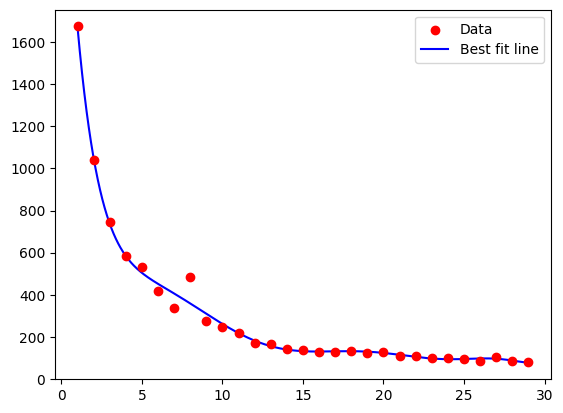

In [37]:
import math

scaler = MinMaxScaler()
X = scaler.fit_transform(df[['LATITUDE', 'LONGITUDE', 'ZIPCODE_AVG', 'SUBLOCALITY_AVG', 'LOCALITY_AVG', 'STREET_NAME_AVG', 'TYPE_AVG']])
#X = scaler.fit_transform(df[['LATITUDE', 'LONGITUDE', 'ZIPCODE_AVG']])

k = 300 # Number of clusters

# use x and y vectors from previous part
x=[]
y=[]
print('k            loss')
for i in range(1,30):
    cluster_assignment, Mu, loss = kmeans_matrix(X, i)
    if math.isnan(loss):
        print('k=', i, ' ', loss)
        continue
    x.append(i)
    y.append(loss)
    print('k=', i, ' ', loss)

fit = np.polyfit(x,y,10)
fit_fn = np.poly1d(fit)

plt.scatter(x, y, label='Data', c='red', zorder=2)
x_values = np.linspace(min(x), max(x), 1000)
plt.plot(x_values, fit_fn(x_values), c='blue', label='Best fit line', zorder=1)
plt.legend()

#plt.plot(x, y)
plt.show()

#### Assign Clusters to each sale

In [38]:
cluster_assignment, centers, _ = kmeans_matrix(X, k)
df['cluster'] = cluster_assignment
df['cluster'].value_counts()

99     73
212    68
87     65
15     58
123    57
       ..
19      1
74      1
290     1
156     1
75      1
Name: cluster, Length: 300, dtype: int64

In [39]:
gb = df.groupby('cluster')['PRICE'].mean().sort_values(ascending=True)
#gb_df = gb.reset_index()
#rename_dict = {y: x for x,y in zip(gb_df.index.to_list(), gb_df['cluster'].to_list())}
df['cluster_avg'] = df['cluster'].apply(lambda x: gb[x])
df

,TYPE,BEDS,BATH,PROPERTYSQFT,LOCALITY,SUBLOCALITY,STREET_NAME,LATITUDE,LONGITUDE,ZIPCODE,PRICE,ZIPCODE_AVG,SUBLOCALITY_AVG,LOCALITY_AVG,STREET_NAME_AVG,TYPE_AVG,cluster,cluster_avg
0,Condo,2,2.000000,1400.000000,New York,Manhattan,East 55th Street,40.761255,-73.974483,10022,315000,2.207520e+06,3.609905e+06,2.256825e+06,2.757500e+06,2.414565e+06,246,2.024667e+06
1,House,4,2.000000,2015.000000,New York,Richmond County,Staten Island,40.541805,-74.196109,10312,260000,1.098239e+06,9.556646e+05,2.256825e+06,9.556646e+05,1.563741e+06,86,8.371456e+05
2,Condo,3,1.000000,445.000000,New York,New York County,New York,40.761398,-73.974613,10022,69000,2.207520e+06,9.542750e+06,2.256825e+06,9.562267e+06,2.414565e+06,273,2.246917e+06
3,Townhouse,7,2.373861,14175.000000,New York,New York County,New York,40.767224,-73.969856,10065,55000000,7.241773e+06,9.542750e+06,2.256825e+06,9.562267e+06,6.365925e+06,53,1.763512e+07
4,House,5,2.000000,4004.000000,New York,Kings County,Brooklyn,40.674363,-73.958725,11238,690000,2.012393e+06,1.795465e+06,2.256825e+06,1.795465e+06,1.563741e+06,72,2.684000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,Co-op,1,1.000000,2184.207862,New York County,New York,Manhattan,40.774350,-73.955879,10075,599000,7.767854e+06,2.534033e+06,2.579619e+06,2.579619e+06,1.100418e+06,15,4.676983e+06
4795,Co-op,1,1.000000,2184.207862,New York,Queens County,Queens,40.732538,-73.860152,11374,245000,6.471313e+05,1.135774e+06,2.256825e+06,1.135774e+06,1.100418e+06,122,4.445404e+05
4796,Co-op,1,1.000000,2184.207862,New York,New York County,New York,40.745882,-74.003398,10011,1275000,7.506142e+06,9.542750e+06,2.256825e+06,9.562267e+06,1.100418e+06,131,1.449000e+07
4797,Condo,2,1.000000,655.000000,Queens County,Queens,Flushing,40.742770,-73.872752,11373,598125,6.425978e+05,4.437331e+05,4.430085e+05,5.198082e+05,2.414565e+06,112,5.898003e+05


#### Plot the correlation matrix

<AxesSubplot: >

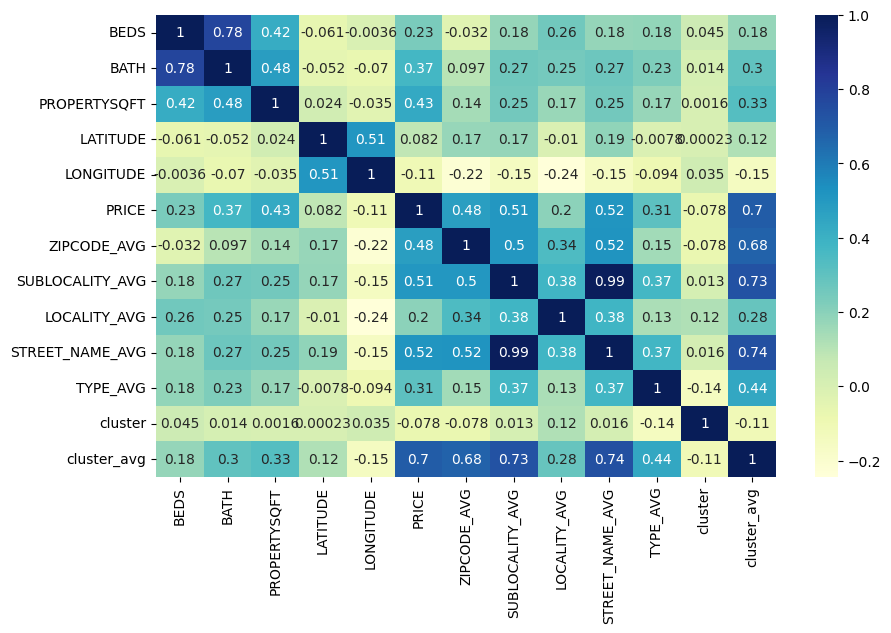

In [40]:
plt.figure(figsize=(10,6))
df_corr = df.corr()
sns.heatmap(df_corr, annot=True, cmap='YlGnBu')

## Plotting Clusters

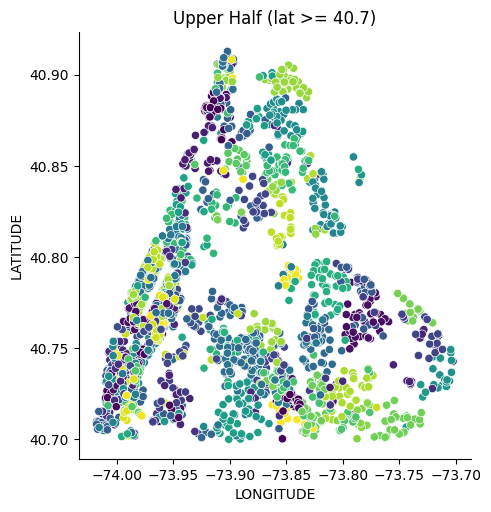

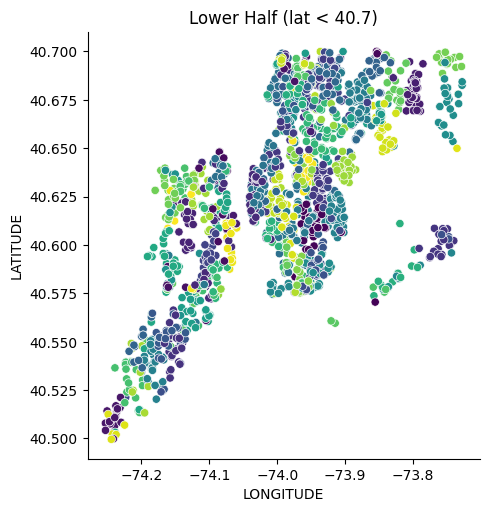

In [41]:
custom_palette1 = sns.color_palette("viridis", n_colors=len(df.loc[df.LATITUDE >= 40.7]['cluster'].unique()))
custom_palette2 = sns.color_palette("viridis", n_colors=len(df.loc[df.LATITUDE < 40.7]['cluster'].unique()))
ax1 = sns.relplot(data=df.loc[df.LATITUDE >= 40.7], x='LONGITUDE', y='LATITUDE', palette=custom_palette1, hue='cluster', aspect=1, legend=False)
ax1.set(title='Upper Half (lat >= 40.7)')
ax2 = sns.relplot(data=df.loc[df.LATITUDE < 40.7], x='LONGITUDE', y='LATITUDE', palette=custom_palette2, hue='cluster', aspect=1, legend=False)
ax2.set(title='Lower Half (lat < 40.7)')
plt.show()
#df.groupby('cluster')['PRICE'].mean().sort_values(ascending=False)

## Cleaning data for modeling

#### Drop features that aren't necessary for the model

In [42]:
df_copy = df.copy()
df = df.drop(columns=['LONGITUDE', 'LATITUDE'], axis=1)
df

,TYPE,BEDS,BATH,PROPERTYSQFT,LOCALITY,SUBLOCALITY,STREET_NAME,ZIPCODE,PRICE,ZIPCODE_AVG,SUBLOCALITY_AVG,LOCALITY_AVG,STREET_NAME_AVG,TYPE_AVG,cluster,cluster_avg
0,Condo,2,2.000000,1400.000000,New York,Manhattan,East 55th Street,10022,315000,2.207520e+06,3.609905e+06,2.256825e+06,2.757500e+06,2.414565e+06,246,2.024667e+06
1,House,4,2.000000,2015.000000,New York,Richmond County,Staten Island,10312,260000,1.098239e+06,9.556646e+05,2.256825e+06,9.556646e+05,1.563741e+06,86,8.371456e+05
2,Condo,3,1.000000,445.000000,New York,New York County,New York,10022,69000,2.207520e+06,9.542750e+06,2.256825e+06,9.562267e+06,2.414565e+06,273,2.246917e+06
3,Townhouse,7,2.373861,14175.000000,New York,New York County,New York,10065,55000000,7.241773e+06,9.542750e+06,2.256825e+06,9.562267e+06,6.365925e+06,53,1.763512e+07
4,House,5,2.000000,4004.000000,New York,Kings County,Brooklyn,11238,690000,2.012393e+06,1.795465e+06,2.256825e+06,1.795465e+06,1.563741e+06,72,2.684000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,Co-op,1,1.000000,2184.207862,New York County,New York,Manhattan,10075,599000,7.767854e+06,2.534033e+06,2.579619e+06,2.579619e+06,1.100418e+06,15,4.676983e+06
4795,Co-op,1,1.000000,2184.207862,New York,Queens County,Queens,11374,245000,6.471313e+05,1.135774e+06,2.256825e+06,1.135774e+06,1.100418e+06,122,4.445404e+05
4796,Co-op,1,1.000000,2184.207862,New York,New York County,New York,10011,1275000,7.506142e+06,9.542750e+06,2.256825e+06,9.562267e+06,1.100418e+06,131,1.449000e+07
4797,Condo,2,1.000000,655.000000,Queens County,Queens,Flushing,11373,598125,6.425978e+05,4.437331e+05,4.430085e+05,5.198082e+05,2.414565e+06,112,5.898003e+05


#### One-Hot Encode the sublocality, locality, and type features

In [43]:
#df_copy = pd.get_dummies(data=df_copy, columns=['TYPE'], drop_first=True)
#df = pd.get_dummies(data=df, columns=['TYPE'], drop_first=True)
df_copy = df_copy.drop(['LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'ZIPCODE', 'TYPE', 'cluster'], axis=1)
#df = df.drop(['LOCALITY'], axis=1)
df_copy

,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE,ZIPCODE_AVG,SUBLOCALITY_AVG,LOCALITY_AVG,STREET_NAME_AVG,TYPE_AVG,cluster_avg
0,2,2.000000,1400.000000,40.761255,-73.974483,315000,2.207520e+06,3.609905e+06,2.256825e+06,2.757500e+06,2.414565e+06,2.024667e+06
1,4,2.000000,2015.000000,40.541805,-74.196109,260000,1.098239e+06,9.556646e+05,2.256825e+06,9.556646e+05,1.563741e+06,8.371456e+05
2,3,1.000000,445.000000,40.761398,-73.974613,69000,2.207520e+06,9.542750e+06,2.256825e+06,9.562267e+06,2.414565e+06,2.246917e+06
3,7,2.373861,14175.000000,40.767224,-73.969856,55000000,7.241773e+06,9.542750e+06,2.256825e+06,9.562267e+06,6.365925e+06,1.763512e+07
4,5,2.000000,4004.000000,40.674363,-73.958725,690000,2.012393e+06,1.795465e+06,2.256825e+06,1.795465e+06,1.563741e+06,2.684000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
4794,1,1.000000,2184.207862,40.774350,-73.955879,599000,7.767854e+06,2.534033e+06,2.579619e+06,2.579619e+06,1.100418e+06,4.676983e+06
4795,1,1.000000,2184.207862,40.732538,-73.860152,245000,6.471313e+05,1.135774e+06,2.256825e+06,1.135774e+06,1.100418e+06,4.445404e+05
4796,1,1.000000,2184.207862,40.745882,-74.003398,1275000,7.506142e+06,9.542750e+06,2.256825e+06,9.562267e+06,1.100418e+06,1.449000e+07
4797,2,1.000000,655.000000,40.742770,-73.872752,598125,6.425978e+05,4.437331e+05,4.430085e+05,5.198082e+05,2.414565e+06,5.898003e+05


## Pipelining different regression methods
Pipelining can be leveraged to determine the best model to use

In [44]:
X = df_copy.drop(['PRICE', 'LONGITUDE', 'LATITUDE'], axis=1)#[['cluster', 'PROPERTYSQFT', 'BEDS', 'BATH']]
y = df_copy['PRICE']
print(X.columns)

#scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr=Pipeline([("scalar1",MinMaxScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",MinMaxScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",MinMaxScaler()),
                     ("rf_classifier",RandomForestRegressor())])

pipeline_kn=Pipeline([("scalar4",MinMaxScaler()),
                     ("rf_classifier",KNeighborsRegressor())])

pipeline_xgb=Pipeline([("scalar5",MinMaxScaler()),
                     ("rf_classifier",XGBRegressor())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

Index(['BEDS', 'BATH', 'PROPERTYSQFT', 'ZIPCODE_AVG', 'SUBLOCALITY_AVG',
       'LOCALITY_AVG', 'STREET_NAME_AVG', 'TYPE_AVG', 'cluster_avg'],
      dtype='object')


#### Display the R2, Adjusted R2, MAE, MSE, and RMSE for each regression method

In [45]:
"""pred = pipeline_xgb.predict(X_test)
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))"""

for i, model in enumerate(pipelines):
    print(pipe_dict[i])
    pred = model.predict(X_test)
    print("R^2:",metrics.r2_score(y_test, pred))
    print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    print("MAE:",metrics.mean_absolute_error(y_test, pred))
    print("MSE:",metrics.mean_squared_error(y_test, pred))
    print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

LinearRegression
R^2: 0.4954141567644317
Adjusted R^2: 0.49063386982851576
MAE: 1059896.1935597965
MSE: 11607093513776.031
RMSE: 3406918.477712085
DecisionTree
R^2: 0.30863917354445936
Adjusted R^2: 0.30208943939909105
MAE: 977665.9211241883
MSE: 15903517452994.764
RMSE: 3987921.445188554
RandomForest
R^2: 0.7142654782074926
Adjusted R^2: 0.7115585195799847
MAE: 705110.6150857742
MSE: 6572810868598.552
RMSE: 2563749.3771034935
KNeighbors
R^2: 0.5869983115725903
Adjusted R^2: 0.5830856639980149
MAE: 854581.8641666666
MSE: 9500364077171.209
RMSE: 3082266.062034751
XGBRegressor
R^2: 0.6707978852507419
Adjusted R^2: 0.6676791283741701
MAE: 719976.812915039
MSE: 7572704985786.881
RMSE: 2751854.8264374123


## Testing different K-Means algorithms

In [91]:
k_start = 680
k_end = 710
num_of_center_tests = 5

#### Test kmeans_alt algorithm

In [47]:
asdf.

SyntaxError: invalid syntax (1484903687.py, line 1)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import time

model_name = ""
best_model = pipeline_xgb
best_score = np.NINF
best_centers = []
best_k = 0
best_df = df_copy
time_of_best = np.inf

pipe_main = [pipelines[2], pipelines[3], pipelines[4]]
pipe_main_dict = {0: "Random Forest", 1: "KNeighbors", 2: "XGBRegressor"}
ks = []
errors = []

df_adj = df_copy.copy()

#X = scaler.fit_transform(df_copy[['LATITUDE', 'LONGITUDE', 'PRICE']])
#y = df_copy['PRICE']
X_fit = scaler.fit_transform(df_adj.drop(['PRICE', 'LATITUDE', 'LONGITUDE', 'cluster_avg'], axis=1))
k_tmp = k_start
# for k in range(k_start, k_end + 1)
while k_start <= k_end:
    avg_score = 0
    start = time.time()
    for _ in range(num_of_center_tests):
        cluster_assignment, centers, _ = kmeans_alt(X_fit, k)
        
        df_adj['cluster'] = cluster_assignment
        gb = df_adj.groupby('cluster')['PRICE'].mean().sort_values(ascending=True)

        #gb_df = gb.reset_index()
        #rename_dict = {y: x for x,y in zip(gb_df.index.to_list(), gb_df['cluster'].to_list())}
        
        df_adj['cluster_avg'] = df_adj['cluster'].apply(lambda x: gb[x])
        X = df_adj.drop(['PRICE', 'LATITUDE', 'LONGITUDE', 'cluster', 'ZIPCODE_AVG', 'SUBLOCALITY_AVG', 'LOCALITY_AVG', 'STREET_NAME_AVG', 'TYPE_AVG'], axis=1)#[['cluster', 'PROPERTYSQFT', 'BEDS', 'BATH']]
        #print(X.columns)
        X = scaler.fit_transform(X)
        
        y = df_adj['PRICE']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Fit the pipelines
        for pipe in pipe_main:
            pipe.fit(X_train, y_train)
        for i, model in enumerate(pipe_main):
            pred = model.predict(X_test)
            R2 = metrics.r2_score(y_test, pred)
            avg_score += R2
            if R2 > best_score:
                best_centers = centers
                model_name = pipe_main_dict[i]
                best_model = model
                best_score = R2
                best_k = k_start
                best_df = df_adj.copy()
    end = time.time()
    ks.append(k_start)
    errors.append(avg_score/(num_of_center_tests*len(pipe_main)))
    print(f"k={k_start} time={end-start} avg_score={avg_score/(num_of_center_tests*len(pipe_main))}")
    k_start += 5

k_start = k_tmp

print(model_name)
pred = best_model.predict(X_test)
print("R^2:",best_score)
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))
print("Best K:", best_k)
best_df # 0.7452227225331807

k=590 time=97.11754012107849 avg_score=0.27623075297408495
Random Forest
R^2: 0.4303384490580462
Adjusted R^2: 0.36984668669072673
MAE: 1215802.1232290512
MSE: 14435087149432.229
RMSE: 3799353.517301625
Best K: 590


,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE,ZIPCODE_AVG,SUBLOCALITY_AVG,LOCALITY_AVG,STREET_NAME_AVG,TYPE_AVG,cluster_avg,cluster
0,2,2.000000,1400.000000,40.761255,-73.974483,315000,2.207520e+06,3.609905e+06,2.256825e+06,2.757500e+06,2.414565e+06,1.869803e+06,1
1,4,2.000000,2015.000000,40.541805,-74.196109,260000,1.098239e+06,9.556646e+05,2.256825e+06,9.556646e+05,1.563741e+06,1.869803e+06,1
2,3,1.000000,445.000000,40.761398,-73.974613,69000,2.207520e+06,9.542750e+06,2.256825e+06,9.562267e+06,2.414565e+06,1.869803e+06,1
3,7,2.373861,14175.000000,40.767224,-73.969856,55000000,7.241773e+06,9.542750e+06,2.256825e+06,9.562267e+06,6.365925e+06,1.869803e+06,1
4,5,2.000000,4004.000000,40.674363,-73.958725,690000,2.012393e+06,1.795465e+06,2.256825e+06,1.795465e+06,1.563741e+06,1.869803e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4794,1,1.000000,2184.207862,40.774350,-73.955879,599000,7.767854e+06,2.534033e+06,2.579619e+06,2.579619e+06,1.100418e+06,1.869803e+06,1
4795,1,1.000000,2184.207862,40.732538,-73.860152,245000,6.471313e+05,1.135774e+06,2.256825e+06,1.135774e+06,1.100418e+06,1.869803e+06,1
4796,1,1.000000,2184.207862,40.745882,-74.003398,1275000,7.506142e+06,9.542750e+06,2.256825e+06,9.562267e+06,1.100418e+06,1.869803e+06,1
4797,2,1.000000,655.000000,40.742770,-73.872752,598125,6.425978e+05,4.437331e+05,4.430085e+05,5.198082e+05,2.414565e+06,1.869803e+06,1


#### Created a kmeans matrix algorithm using random kmeans plus centers

#### Test K-Means Matrix algorithm

In [92]:
import warnings
warnings.filterwarnings('ignore')
import time

model_name = ""
best_model = pipeline_xgb
best_score = np.NINF
best_centers = []
best_k = 0
best_df = df_copy
time_of_best = np.inf

pipe_main = [pipelines[2], pipelines[3], pipelines[4]]
pipe_main_dict = {0: "Random Forest", 1: "KNeighbors", 2: "XGBRegressor"}
ks = []
errors = []

df_adj = df_copy.copy()

X_fit = scaler.fit_transform(df_adj.drop(['PRICE', 'LATITUDE', 'LONGITUDE', 'cluster_avg', 'LOCALITY_AVG', 'TYPE_AVG'], axis=1))
k_tmp = k_start

drop_list = ['PRICE', 'LATITUDE', 'LONGITUDE', 'cluster', 'ZIPCODE_AVG', 'SUBLOCALITY_AVG', 'LOCALITY_AVG', 'STREET_NAME_AVG', 'TYPE_AVG']
while k_start <= k_end:

    local_best_score = np.NINF
    start = time.time()

    for _ in range(num_of_center_tests):

        cluster_assignment, centers, _ = kmeans_matrix(X_fit, k_start, max_iter=1000, err=1e-8)
        df_adj['cluster'] = cluster_assignment
        gb = df_adj.groupby('cluster')['PRICE'].mean().sort_values(ascending=True)
        df_adj['cluster_avg'] = df_adj['cluster'].apply(lambda x: gb[x])

        X = scaler.fit_transform(df_adj.drop(drop_list, axis=1))
        y = df_adj['PRICE']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Fit the pipelines
        for pipe in pipe_main:
            pipe.fit(X_train, y_train)
        for i, model in enumerate(pipe_main):
            pred = model.predict(X_test)
            R2 = metrics.r2_score(y_test, pred)
            #avg_score += R2
            if R2 > local_best_score:
                local_best_score = R2
            if R2 > best_score:
                best_centers = centers
                model_name = pipe_main_dict[i]
                best_model = model
                best_score = R2
                best_k = k_start
                best_df = df_adj.copy()
    end = time.time()
    ks.append(k_start)
    errors.append(local_best_score)
    print(f"k={k_start} time={end-start} best_score={local_best_score}")
    k_start += 10

k_start = k_tmp

print(model_name)
pred = best_model.predict(X_test)
print("R^2:",best_score)
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))
print("Best K:", best_k)
X_test, y_test # 0.7452227225331807

k=1000 time=99.81457543373108 best_score=0.8809422197844746
KNeighbors
R^2: 0.8809422197844746
Adjusted R^2: 0.880443548453729
MAE: 528561.48375
MSE: 2738710978577.819
RMSE: 1654905.126760389
Best K: 1000


(array([[0.10204082, 0.04      , 0.04103821, 0.01485038],
        [0.10204082, 0.08      , 0.02881862, 0.02103002],
        [0.        , 0.02      , 0.02992432, 0.00952414],
        ...,
        [0.02040816, 0.04      , 0.02992432, 0.00884414],
        [0.02040816, 0.02      , 0.02992432, 0.00910197],
        [0.10204082, 0.08      , 0.05772912, 0.05933991]]),
 3826     775000
 491     1300000
 3747    1295000
 3741     165000
 287     1375000
          ...   
 4794     599000
 4006     799000
 4575     498000
 1770     825000
 1469    5995000
 Name: PRICE, Length: 960, dtype: int64)

In [103]:
X_train[-10:], y_train[-10:]

(array([[0.06122449, 0.02      , 0.01485338, 0.0047743 ],
        [0.04081633, 0.04747722, 0.02992432, 0.01871898],
        [0.02040816, 0.02      , 0.01059643, 0.01491583],
        [0.02040816, 0.02      , 0.01405712, 0.00634324],
        [0.08163265, 0.12      , 0.02992432, 0.24304261],
        [0.08163265, 0.08      , 0.02992432, 0.11117186],
        [0.02040816, 0.02      , 0.02992432, 0.00402889],
        [0.04081633, 0.04747722, 0.02992432, 0.00842397],
        [0.        , 0.02      , 0.007197  , 0.00874775],
        [0.02040816, 0.02      , 0.02992432, 0.00613838]]),
 1685      379000
 130      1249000
 2919      875000
 3171      399985
 3444    15850000
 4426     4150000
 466       259500
 3092     1400000
 3772      699000
 860       350000
 Name: PRICE, dtype: int64)

array([3274420.8], dtype=float32)

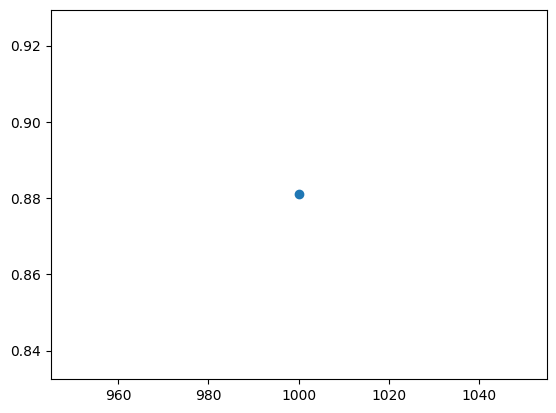

In [104]:
plt.scatter(x=ks, y=errors)
#df_copy.columns
model.predict([[0.08163265,0.08,0.02992432,0.11117186]])

In [ ]:
X_fit = scaler.fit_transform(best_df[['LATITUDE', 'LONGITUDE', 'PRICE']])

best_df['pred'] = best_model.predict()

TypeError: Pipeline.predict() missing 1 required positional argument: 'X'

In [ ]:
gb = best_df.groupby('cluster')['PRICE'].mean().sort_values(ascending=False)
best_df.loc[best_df.cluster == gb.index.to_list()[0]]

,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE,PRICE,ZIPCODE_AVG,SUBLOCALITY_AVG,LOCALITY_AVG,STREET_NAME_AVG,TYPE_AVG,cluster_avg,cluster
2105,8,10.0,16000.0,40.776402,-73.962948,36000000,7.767854e+06,9.542750e+06,2.256825e+06,9.562267e+06,1.340867e+06,36000000.0,265


In [ ]:
print(model_name)
pred = best_model.predict(X_test)
print("R^2:",best_score)
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))
print("Best K:", best_k)
best_centers
# R^2: 0.9582612654639162 
# R^2: 0.9601463295116474 only one hot type
# R^2: 0.9582492372452774 no one hot
# R^2: 0.7491441384615792 with clustering
# R^2: 0.7471422219588864 w/o clustering

KNeighbors
R^2: 0.8370307430011282
Adjusted R^2: 0.7449320747689427
MAE: 676741.5729166666
MSE: 5842907832062.958
RMSE: 2417210.7545811883
Best K: 590


: 

In [64]:
print(model_name)
pred = best_model.predict(X_test)
print("R^2:",best_score)
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))
print("Best K:", best_k)
best_centers
# R^2: 0.9582612654639162 
# R^2: 0.9601463295116474 only one hot type
# R^2: 0.9582492372452774 no one hot
# R^2: 0.7491441384615792 with clustering
# R^2: 0.7471422219588864 w/o clustering

KNeighbors
R^2: 0.896042108048801
Adjusted R^2: 0.8516892372150684
MAE: 607769.1102083334
MSE: 3397393524373.2246
RMSE: 1843201.9760116427
Best K: 690


array([[0.02040816, 0.02      , 0.0133221 , 0.31405279, 0.06964632,
        0.18009636],
       [0.04081633, 0.04747722, 0.84327387, 0.03827572, 0.09871345,
        0.06172308],
       [0.02040816, 0.04      , 0.01164169, 0.04218532, 0.02438322,
        0.02247388],
       ...,
       [0.07346939, 0.08      , 0.06360922, 0.19685795, 0.16943686,
        0.10075224],
       [0.23469388, 0.08      , 0.02992432, 0.11122775, 0.16943686,
        0.10075224],
       [0.14285714, 0.2       , 0.12449276, 0.37507776, 0.24861655,
        0.14714505]])

#### Evaluate the runtime and cv_score of each regression method used

In [ ]:
"""import time
cv_results_rms = []
for i, model in enumerate(pipelines):
    start = time.time()
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    end = time.time()
    cv_results_rms.append(cv_score)
    print("%s: %f time: %f" % (pipe_dict[i], cv_score.mean(), end-start))"""

'import time\ncv_results_rms = []\nfor i, model in enumerate(pipelines):\n    start = time.time()\n    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)\n    end = time.time()\n    cv_results_rms.append(cv_score)\n    print("%s: %f time: %f" % (pipe_dict[i], cv_score.mean(), end-start))'

#### Display the 10 most import features for predicting the price
As you can see from this list, clustering was a very useful tactic for my predicative model.

In [63]:
coef = best_model.named_steps['rf_classifier'].feature_importances_
print(len(best_df.drop(['LATITUDE', 'LONGITUDE', 'PRICE','cluster'], axis=1).columns.to_list()))
print(len(coef))
weights = {x: y for x,y in zip(best_df.drop(['LATITUDE', 'LONGITUDE', 'PRICE'], axis=1).columns.to_list(), coef)}
weights = sorted(weights.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
weights#[:10]

AttributeError: 'KNeighborsRegressor' object has no attribute 'feature_importances_'